In [1]:
import numpy as np
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
import Iterator as it
from DS import DS
from Set import pool
from FFModel import FF_Model
from RNNModel import RNN_Model

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
#Dataset.process_for_embedding()
#sentences = Dataset.get_sentences()
#fn.write_sentences('sentences')
sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')
model = Word2Vec.load('W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Layer and Index Loading

In [5]:
#word_indices, emb_layer = fn.get_index_and_emb_layer(model)
#fn.write_word_indices(word_indices, 'word_indices')
#fn.write_emb_layer(emb_layer, 'emb_layer')

word_indices = fn.load_word_indices('word_indices')
emb_layer = fn.load_emb_layer('emb_layer')

Word Indices Load Complete
Embedding Layer Load Complete


# RNN Testing

In [15]:
    import re

    def process_for_testing(self):
        text = self.raw_text
        text = text.split('\n')
        for i in range(len(text)):
            text[i] = text[i].strip('.')  # Removing stops from end of lines
            text[i] = re.sub(r'\d+', '<NUM>', text[i])  # Substituting numbers with number tokens
            text[i] = re.sub(r'([A-Za-z]):', r'\1', text[i])  # Removing colons from letter words
            text[i] = re.sub(r'Dr\.', 'Dr', text[i])
            text[i] = re.sub(r'Mr\.', 'Mr', text[i])
            text[i] = re.sub(r'([A-Za-z])\.', r'\1', text[i])
            text[i] = re.sub(r'([A-Za-z]);', r'\1', text[i])
            text[i] = text[i].lower()
            text[i] = text[i].split()
        self.token_text = text

        indices = []
        second = False
        for term in re.finditer(r'do="[^|]+\|', self.raw_labels):
            term = term.group()
            index = []
            for window in re.finditer(r'\d+:\d+', term):
                index.append(list(map(int, window.group().split(':'))))
                if second:
                    if index not in indices:
                        indices.append(index)
                    index = []
                second = not second
        indices.sort()
        indices.append([[0, 0], [0, 0]])

        truth = []
        c = 0
        inside = False
        for i in range(len(text)):
            for j in range(len(text[i])):
                if inside:
                    if i + 1 < indices[c][1][0]:
                        truth.append([1, 0])
                    elif i + 1 == indices[c][1][0]:
                        if j < indices[c][1][1]:
                            truth.append([1, 0])
                        elif j == indices[c][1][1]:
                            truth.append([1, 0])
                            inside = False
                            c += 1
                else:
                    if [i + 1, j] == indices[c][0]:
                        truth.append([1, 0])
                        if [i + 1, j] == indices[c][1]:
                            c += 1
                        else:
                            inside = True
                    else:
                        truth.append([0, 1])
        self.test_labels = truth
        self.test_text = [word for row in self.token_text for word in row]
        
    def process_for_testing_set(self):
        for i in range(self.size):
            process_for_testing(self.data[i])

In [32]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

process_for_testing_set(train_cases)
process_for_testing_set(validation_cases)
process_for_testing_set(test_cases)

In [33]:
lw, rw = 3, 3
sets = {}
sets['train_set'], sets['train_labels'], _, sets['train_lengths'] = train_cases.get_rnn_sets(word_indices, lw, rw)
sets['validation_set'], sets['validation_labels'], _, sets['validation_lengths']= validation_cases.get_rnn_sets(word_indices, lw, rw)
sets['test_set'], sets['test_labels'], sets['test_words'], sets['test_lengths'] = test_cases.get_rnn_sets(word_indices, lw, rw)

In [34]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1, seqlen=True)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.03% non-med: 0.97%
Ratio: med: 0.11% non-med: 0.89%


C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))
C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


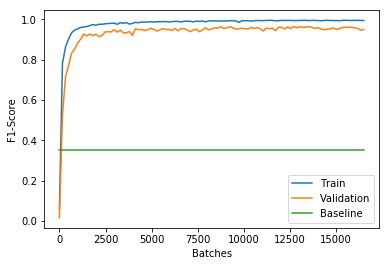

FInal Values: Tr-F1: 0.9942, Val-F1: 0.9489
Test F1-Score: 0.9288



In [35]:
RNN = RNN_Model(vocab_size=len(word_indices), state_size=100, num_classes=2, learn_rate=0.001, emb_layer=emb_layer)
RNN.build_graph()
_,_,_, = RNN.train(sets=sets, epochs=3, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [36]:
res = RNN.predict(sets['test_set'], sets['test_lengths'])
tru = np.argmax(sets['test_labels'], 1)

In [37]:
_ = fn.token_perf(res, tru)

TP	TN	FP	FN
359	10747	29	26

Precision: 0.9253
Recall: 0.9325
F1-Score: 0.9288


In [38]:
baseline = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.23354231974921627

In [39]:
fn.category_words(sets['test_words'], res, tru, 1, 0)

boluses, of, dosed, for, level, less, than, <num>, dose, <num>mg, dose, <num>mg, mg, <num>.<num>., halved, <num>, unit, <num>, dose, of, her, normal, dose, <num>, <num>, ou


In [40]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [42]:
from collections import Counter

a = [1, 2, 3, 4, 5, 1, 1, 3, 2]
c = Counter(a)
c

Counter({1: 3, 2: 2, 3: 2, 4: 1, 5: 1})

In [84]:
import colorama as col

def phrase_perf(NN, testers, model, side_words=[0, 0], tfpn=True, precision=True, recall=True, f1=True, case_info=False, show_phrases=False, rnn=False):
    perf_dict = {'tp': 0, 'fp': 0, 'fn': 0}

    for i in range(testers.size):
        current_ds = pool(data=[testers.data[i]])
        if case_info:
            current_ds.show_info()
        current_ds.process_for_testing()

        if not rnn:
            cur_set = current_ds.get_ff_sets(model=model, left_words=side_words[0], right_words=side_words[1])
            cur_res = NN.predict(cur_set[0])
        else:
            cur_set = current_ds.get_rnn_sets(word_indices=model, left_words=side_words[0], right_words=side_words[1])
            cur_res = NN.predict(cur_set[0], cur_set[3])

        res_words = []
        res_inside = False
        res_med = ''
        for k in range(len(cur_set[2])):
            if not res_inside:
                if cur_res[k] == 0:
                    res_med = cur_set[2][k]
                    res_inside = True
            else:
                if cur_res[k] == 0:
                    res_med = res_med + ' ' + cur_set[2][k]
                else:
                    res_words.append(res_med)
                    res_med = 0
                    res_inside = False
                    
        tru_terms = []
        tru_words = []
        for term in re.finditer(r'do="[^|]+\|', current_ds.data[0].raw_labels):
            term = term.group()
            if term not in tru_terms:
                tru_terms.append(term)
                term = re.match(r'do="[^"]+"', term).group()[4:-1]
                term = re.sub(r'\d+', '<num>', term)
                term = re.sub(r'([A-Za-z]);', r'\1', term)
                term = re.sub(r'([A-Za-z])\.', r'\1', term)
                if not term == 'nm': tru_words.append(term)
                    
        res_count = Counter(res_words)
        tru_count = Counter(tru_words)
        dif_count = Counter(res_words)
        dif_count.subtract(Counter(tru_words))
        

        if show_phrases:
            print('Result Dosages:')
            print(*res_count.most_common() + ['\n'])
            print('True Dosages:')
            print(*tru_count.most_common() + ['\n'])

        perf_dict['tp'] += sum([res_count[word] - max(0, dif_count[word]) for word in dif_count.keys()])
        perf_dict['fp'] += sum([max(0, dif_count[word]) for word in dif_count.keys()])
        perf_dict['fn'] += sum([-min(0, dif_count[word]) for word in dif_count.keys()])

    perf_dict['precision'] = perf_dict['tp'] / (perf_dict['tp'] + perf_dict['fp'])
    perf_dict['recall'] = perf_dict['tp'] / (perf_dict['tp'] + perf_dict['fn'])
    perf_dict['f1'] = (2 * perf_dict['tp']) / (2 * perf_dict['tp'] + perf_dict['fn'] + perf_dict['fp'])

    if tfpn:
        print('TP\tFP\tFN\n{}\t{}\t{}\n'.format(perf_dict['tp'], perf_dict['fp'], perf_dict['fn']))
    if precision:
        print('Precision: {:.4f}'.format(perf_dict['precision']))
    if recall:
        print('Recall: {:.4f}'.format(perf_dict['recall']))
    if f1:
        print('F1-Score: {:.4f}'.format(perf_dict['f1']))
    return perf_dict

In [86]:
testers = Dataset.get_DS(stage='train', labelled='yes')
_ = phrase_perf(RNN, testers, word_indices, side_words=[lw, rw], tfpn=True, show_phrases=True, case_info=True, rnn=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


Result Dosages:
('<num> mg', 16) ('sliding scale', 2) ('<num> units', 2) ('<num>-<num> tablets', 1) 

True Dosages:
('<num> mg', 16) ('sliding scale', 2) ('<num> units', 2) ('<num>-<num> tablets', 1) 

Name:  0102
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


Result Dosages:
('<num> mg', 8) ('<num> units', 3) ('<num> liters', 1) ('<num>.<num> mg', 1) ('sliding scale', 1) ('four', 1) ('<num> meq', 1) ('<num> mcg', 1) 

True Dosages:
('<num> mg', 7) ('<num> units', 3) ('<num> liters', 1) ('boluses of <num> mg', 1) ('sliding scale', 1) ('<num> meq', 1) ('<num> mcg', 1) ('<num>.<num> mg', 1) 

Name:  0105
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


Result Dosages:
('<num> mg', 5) ('<num>.<num> mg', 2) ('<num> mg per kg', 1) ('three', 1) ('of five units', 1) ('one

# HyperParameter Scan

In [ ]:
emb_sizes = [100]
emb_models = 1
target_saturations = [0.05, 0.1, 0.2, 0.5, 0.7]
layer_sizes = [50]
dropouts = [1.0]
learn_rates = [0.01]
epochs = [100]
NN_num = 5

case_num = len(emb_sizes)*emb_models*len(layer_sizes)*len(target_saturations)*len(epochs)*len(dropouts)*len(learn_rates)*NN_num
print(case_num)

In [ ]:
max_performance = 0
n = 1

for emb_size in emb_sizes:
    print('Model Number: %d/%d' %(n, case_num))
    for i in range(emb_models):
        model = Word2Vec(sentences, min_count=1, size=emb_size)
        for saturation in target_saturations:
            sets = fn.get_traintest2 (labelled_cases, model)
            fn.saturate_training_set(sets, model, target_dict['medications'], saturation)
            for layer_size in layer_sizes:
                for drop in dropouts:
                    for rate in learn_rates:
                        for epoch in epochs:
                            for j in range(NN_num):
                                print('Model Number: %d/%d' %(n, case_num))
                                print('ES: %d EM: %d sat: %f, LS: %d, drop: %f, LR: %f, epochs: %d, NN: %d' \
                                       % (emb_size, i, saturation, layer_size, drop, rate, epoch, j))
                                NN = FF_Model(input_size=emb_size, layers=[layer_size], dropout=drop, learn_rate=rate)
                                NN.build_graph()
                                NN.train(sets, epochs=epoch)
                                res = NN.predict(sets['test_set'])
                                tru = np.argmax(sets['test_labels'], 1)
                                perf = sk.metrics.f1_score(tru, res, pos_label=0)
                                if perf > max_performance:
                                    max_performance = perf
                                    NN.save_model('gold')
                                    model.save('gold/GOLDEMB')
                                NN.close()
                                n += 1